In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet, Lasso, Ridge

from sklearn.model_selection import (
  train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
)

from functions import *

import warnings
from sklearn.exceptions import ConvergenceWarning

%load_ext autoreload
%autoreload 2

lags = 7

# Load each
datasets = {}
for hour in range(24):
    df = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

    datasets[hour] = deseasonalize(df, "both")

    for i in range(1, lags + 1):
      datasets[hour][f'DK1_spot_lag_{i}'] = datasets[hour]['DK1_spot'].shift(i)
      datasets[hour] = datasets[hour].dropna()

regex_choice = "^(sun_|wind_|temp_|DK1_spot_lag_)"
pca_percent = 0.7

y_train, y_test, y_train_deseason, y_test_deseason, y_train_season, y_test_season, \
exog_variables_train, scalers, exog_variables_train_stand, exog_variables_test, \
exog_variables_test_stand, pca_train, pca_test = split_data_into_series(datasets, pca_percent, regex_choice)

In [7]:
y_test[0].shape

(364, 1)

Hour 0 fitted
Hour 1 fitted
Hour 2 fitted
Hour 3 fitted
Hour 4 fitted
Hour 5 fitted
Hour 6 fitted
Hour 7 fitted
Hour 8 fitted
Hour 9 fitted
Hour 10 fitted
Hour 11 fitted
Hour 12 fitted
Hour 13 fitted
Hour 14 fitted
Hour 15 fitted
Hour 16 fitted
Hour 17 fitted
Hour 18 fitted
Hour 19 fitted
Hour 20 fitted
Hour 21 fitted
Hour 22 fitted
Hour 23 fitted
SMAPE baseline (24 lags) out of sample prediction: (130.23870530236903, 47.57024502929273, 81.4705557367894)


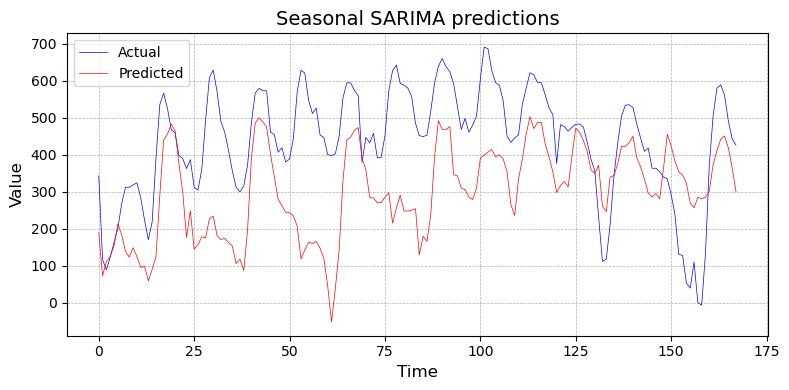

In [ ]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)

predictions_dict = {}
optimal_lambda_dict = {}
optimal_rho_dict = {}
final_mspe_dict = {}

for hour in range(24):
    X_train_lasso, X_validation_lasso, y_train_lasso, y_validation_lasso = train_test_split(exog_variables_train_stand[hour], y_train_deseason[hour], test_size=0.2, random_state=42)

    lambdaa = np.exp(np.log(10) * np.linspace(np.log10(0.00001), np.log10(100), 20))
    rho = np.linspace(0, 1, 10)
    grid = pd.DataFrame(np.array(np.meshgrid(lambdaa, rho)).T.reshape(-1, 2), columns=["x", "y"])

    results = []

    # Define the linear fit function
    def linear_fit_function(x, y, X_train_lasso, X_validation_lasso, y_train_lasso, y_validation_lasso):
        # Create and fit the ElasticNet model
        model = ElasticNet(alpha=x, l1_ratio=y, fit_intercept=True)
        model.fit(X_train_lasso, y_train_lasso)
        
        # Predict on the test set
        y_pred_lasso = model.predict(X_validation_lasso).reshape(-1, 1)
        
        rmse, smape_val, rmae = out_of_sample_pred(y_validation_lasso, y_pred_lasso)

        return rmae

    for _, row in grid.iterrows():
        lambdaa, rho = row["x"], row["y"]
        rmae = linear_fit_function(lambdaa, rho, X_train_lasso, X_validation_lasso, y_train_lasso, y_validation_lasso)
        results.append(rmae)

    # Combine the results into a final DataFrame
    final_mspe_dict[hour] = pd.concat([grid, pd.DataFrame(results, columns=["rmae"])], axis=1)

    best_params = final_mspe_dict[hour].sort_values("rmae").iloc[0]

    optimal_lambda_dict[hour], optimal_rho_dict[hour] = best_params["x"], best_params["y"]

    model = ElasticNet(alpha=optimal_lambda_dict[hour], l1_ratio=optimal_rho_dict[hour], fit_intercept=True)
    model.fit(exog_variables_train_stand[hour], y_train_deseason[hour])

    predictions_dict[hour] = model.predict(exog_variables_test_stand[hour]).reshape(-1, 1) + y_test_season[hour].reshape(-1, 1)

    print(f'Hour {hour} fitted')

warnings.resetwarnings()

combined_predictions, combined_test = combine_24_hour_data(predictions_dict, y_test)

smape_baseline = out_of_sample_pred(combined_test, combined_predictions)

print(f'SMAPE baseline (24 lags) out of sample prediction: {smape_baseline}')

plot_actual_vs_predicted(combined_test, combined_predictions, "Seasonal SARIMA predictions")

In [3]:
combined_predictions_ml = pd.DataFrame(combined_predictions, columns=['Predictions'])
combined_predictions_ml.to_csv('combined_predictions_ml.csv', index=False)

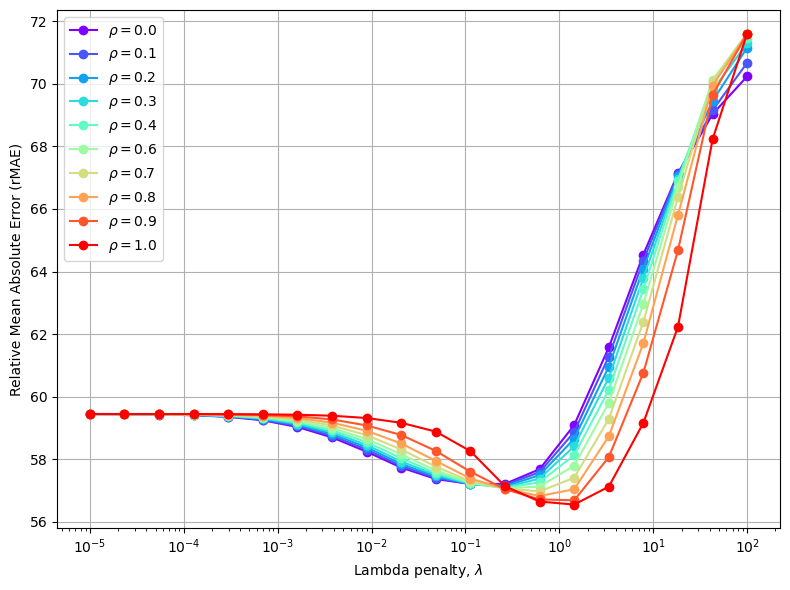

In [4]:
# Rainbow color map
hour = 12

colors = plt.cm.rainbow(np.linspace(0, 1, len(final_mspe_dict[hour]['y'].unique())))

plt.figure(figsize=(8, 6))
for idx, y_value in enumerate(final_mspe_dict[hour]['y'].unique()):
    subset = final_mspe_dict[hour][final_mspe_dict[hour]['y'] == y_value]
    plt.plot(subset['x'], subset['rmae'], marker='o', label=r'$\rho={}$'.format(round(y_value, 1)), color=colors[idx])

plt.xlabel(r'Lambda penalty, $\lambda$')
plt.ylabel('Relative Mean Absolute Error (rMAE)')
# plt.title('Symmetric Mean Average Prediction Error (SMAPE) for ElasticNet')
plt.legend()
plt.xscale('log') 
plt.grid(True)
plt.tight_layout()

plt.show()